In [13]:
%load_ext autoreload
%autoreload 2

import os, sys
import argparse, cv2, logging, pdb
import focus_stacking.registration.ecc as ecc
import focus_stacking.utils.images as im_utils
import focus_stacking.utils.data_loader as data_loader
from focus_stacking.pipelines.scale_transform_pipeline import StackPyramid, Pyramid, LaplacianPyramid
import focus_stacking.utils.pyramids
import focus_stacking.energy.energy as energies
import focus_stacking.fusion.fusion as fusion
import focus_stacking.pipelines.scale_transform_pipeline as scale_transform
import focus_stacking.pipelines.simple_pipeline as simple_pipeline
import focus_stacking.pipelines.utils as pipeline_utils

align_max_iters = 50
align_eps = 1e-3
DATA_ROOT = '/n/fs/3d-indoor/macro_data/focus_stacks'

logger = logging.getLogger(__name__)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
aux_out_dir = '/n/fs/3d-indoor/tmp_outdir/aux/'
registered_images = data_loader.load_images_from_dir(aux_out_dir, match='reg_*.jpg')

In [20]:
ENERGIES = ['local_variance', 'local_entropy', 'local_region', 'laplacian', 'self', 'squared']
FUSION_STRATEGIES = ['max', 'multi_max', 'multi_max_vote', 'min', 'multi_max_mean']
SCALE_TRANSFORMS = ['laplacian_pyramid', 'wavelet']
PIPELINES = ['simple', 'scale_transform']

parser = argparse.ArgumentParser(formatter_class=argparse.RawTextHelpFormatter)
parser.add_argument('--data.obj', type=str, help='top level object directory', dest='obj')
parser.add_argument('--data.view', type=str, help='view dir, formatted as 03:d', dest='view')
parser.add_argument('--data.fnum', choices=['f4.0', 'f5.6', 'f6.3', 'f13', 'f22'], type=str, help='aperture size', dest='fnum')
parser.add_argument('--data.src_dir', type=str, help='manually specify full path to image source directory', dest='src_dir')

parser.add_argument('--register.load', action='store_true', help='if true, load registered images from aux dir and skip alignment', dest='load_reg_images')
parser.add_argument('--register.save_images', action='store_true', help='write registered images to aux output directory', dest='reg_save_im')
parser.add_argument('--register.ref_im_idx', type=int, help='reference image to align image to', dest='ref_im_idx', default=0)
parser.add_argument('--register.res', type=int, help='downscale image by [res] for warping only', dest='warp_res', default=1)
parser.add_argument('--register.max_iters', type=int, help='max iterations for ECC', dest='align_max_iters', default=50)
parser.add_argument('--register.eps', type=float, help='termination eps for ECC', dest='align_eps', default=1e-3)

parser.add_argument('--pipeline', type=str, choices=PIPELINES)

parser.add_argument('--simple.energies', nargs='+', choices=ENERGIES, dest='simple_energies')
parser.add_argument('--simple.fusion', choices=FUSION_STRATEGIES, dest='simple_fusion')

parser.add_argument('--scale_transform.type', type=str, choices=SCALE_TRANSFORMS, help='energies used for pyramid base fusion', dest='st_type')
parser.add_argument('--scale_transform.wavelet_name', type=str, help='energies used for pyramid base fusion', dest='st_wavelet_name')
parser.add_argument('--scale_transform.reassign_ch', action='store_true', dest='st_reassign_ch')
parser.add_argument('--scale_transform.kwidth', type=int, help='kernel width for pyramid construction', default=63, dest='st_kwidth')
parser.add_argument('--scale_transform.depth', type=int, help='pyramid depth/number of levels in pyramid', default=5, dest='st_depth')
parser.add_argument('--scale_transform.base_energies', nargs='+', choices=ENERGIES, help='energies used for pyramid base fusion', dest='st_base_energies')
parser.add_argument('--scale_transform.base_fusion', choices=FUSION_STRATEGIES, help='energies used for pyramid base fusion', dest='st_base_fusion')
parser.add_argument('--scale_transform.level_energies', nargs='+', choices=ENERGIES, help='energies used for pyramid base fusion', dest='st_level_energies')
parser.add_argument('--scale_transform.level_fusion',  choices=FUSION_STRATEGIES, help='energies used for pyramid base fusion', dest='st_level_fusion')

parser.add_argument('--energy.variance.neighborhood', type=int, dest='energy_variance_neighborhood')
parser.add_argument('--energy.entropy.neighborhood', type=int, dest='energy_entropy_neighborhood')
parser.add_argument('--energy.region.neighborhood', type=int, dest='energy_region_neighborhood')
parser.add_argument('--energy.region.kwidth', type=int, dest='energy_region_kwidth')
parser.add_argument('--energy.laplacian.neighborhood', type=int)
parser.add_argument('--energy.laplacian.kwidth', type=int)

parser.add_argument('--out_dir', type=str, help='manually specify output directory')
parser.add_argument('--out_fname', type=str, default='fused_im.jpg')
parser.add_argument('--aux_out_dir', type=str, help='manually specify auxiliary output directory')
parser.add_argument('--results_out_dir', type=str, help='manually specify results output directory')
#subparsers = parser.add_subparsers(dest='method')

cmd_line = ['--data.obj', 'snail',
            '--data.view', '000',
            '--data.fnum', 'f4.0',
            '--pipeline', 'simple',
            '--simple.energies', 'local_variance',
            '--simple.fusion', 'max',
            '--energy.variance.neighborhood', '9',
            '--aux_out_dir', '/n/fs/3d-indoor/tmp_outdir/aux',
            ]
args = parser.parse_args(cmd_line)

In [11]:
fused_im, indices = simple_pipeline.run_pipeline(args, registered_images)

[array([[1.47223473e-05, 1.45435333e-05, 1.47223473e-05, ...,
        1.04904175e-05, 8.25524330e-06, 9.83476639e-06],
       [1.67489052e-05, 1.65700912e-05, 1.61230564e-05, ...,
        9.56654549e-06, 7.92741776e-06, 9.83476639e-06],
       [2.01761723e-05, 2.01165676e-05, 1.92523003e-05, ...,
        9.86456871e-06, 8.73208046e-06, 1.05500221e-05],
       ...,
       [3.69772315e-05, 3.27378511e-05, 4.18126583e-05, ...,
        9.17911530e-06, 9.71555710e-06, 9.00030136e-06],
       [3.62470746e-05, 3.24994326e-05, 3.82363796e-05, ...,
        6.85453415e-06, 7.62939453e-06, 6.91413879e-06],
       [3.90112400e-05, 3.39224935e-05, 3.74317169e-05, ...,
        5.24520874e-06, 5.72204590e-06, 5.06639481e-06]], dtype=float32), array([[2.92062759e-06, 3.51667404e-06, 4.20212746e-06, ...,
        4.04005647e-02, 2.20721271e-02, 1.12841459e-04],
       [2.83122063e-06, 3.42726707e-06, 4.32133675e-06, ...,
        4.03682068e-02, 2.20740046e-02, 1.10907822e-04],
       [4.20212746e-06, 4.

In [7]:
import matplotlib.pyplot as plt

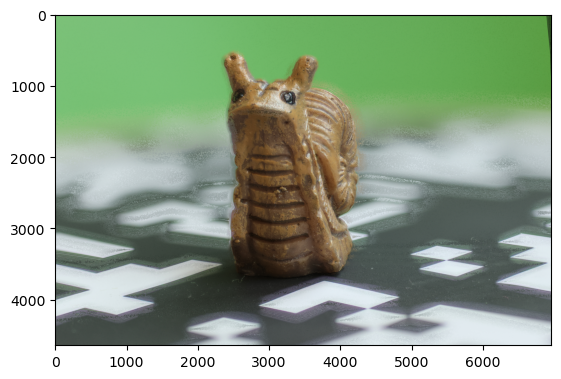

In [12]:
plt.imshow(im_utils.bgr_to_rgb(fused_im))

In [13]:
print(indices)

[[7 7 2 ... 1 1 1]
 [7 2 2 ... 1 1 1]
 [0 0 2 ... 1 1 1]
 ...
 [0 0 0 ... 7 7 7]
 [0 0 0 ... 7 7 7]
 [0 0 0 ... 7 7 7]]


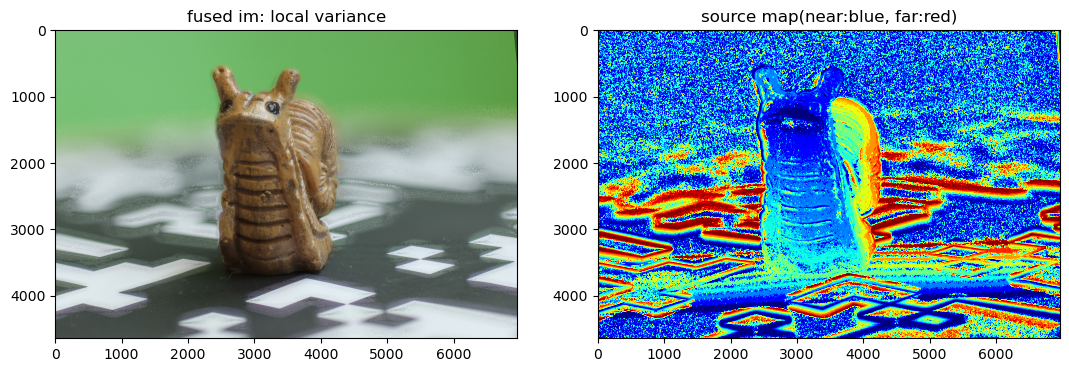

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
ax1.title.set_text('fused im: local variance')
ax1.imshow(im_utils.bgr_to_rgb(fused_im))
ax2.title.set_text(f'source map(near:blue, far:red)')
ax2.imshow(indices, cmap='jet')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [21]:
cmd_line = ['--data.obj', 'snail',
            '--data.view', '000',
            '--data.fnum', 'f4.0',
            '--pipeline', 'scale_transform',
            '--scale_transform.type', 'laplacian_pyramid',
            '--scale_transform.depth', '5',
            '--scale_transform.base_energies', 'local_variance', 'local_entropy',
            '--scale_transform.base_fusion', 'multi_max_mean',
            '--scale_transform.level_energies', 'local_region',
            '--scale_transform.level_fusion', 'max',
            '--energy.variance.neighborhood', '9',
            '--energy.entropy.neighborhood', '9',
            '--energy.region.neighborhood', '9',
            '--energy.region.kwidth', '63',
            '--aux_out_dir', '/n/fs/3d-indoor/tmp_outdir/aux',
            ]
args = parser.parse_args(cmd_line)
# fused_im, reconstruction_pyramid = scale_transform.run_laplacian_pyramid_pipeline(args, registered_images)

In [6]:
low_pass_kernel = cv2.getGaussianKernel(args.st_kwidth, sigma=-1)
stack = StackPyramid(registered_images,
        depth=args.st_depth,
        kernel=low_pass_kernel,
        pyramid_type=args.st_type
        )

NameError: name 'pipeline_utils' is not defined

In [8]:
for energy_name in args.st_level_energies:
    fn = pipeline_utils.get_energy_fn(energy_name, args)
    for pyramid in stack.pyramids:
        for level in range(pyramid.depth):
            pyramid.compute_energy_for_levels(level,
                    im_key='laplacian',
                    energy_fn=fn,
                    energy_key=energy_name
                    )

for energy_name in args.st_base_energies:
    fn = pipeline_utils.get_energy_fn(energy_name, args)
    for pyramid in stack.pyramids:
        pyramid.compute_energy_for_levels(-1,
                im_key='laplacian',
                energy_fn=fn,
                energy_key=energy_name
                )

/n/fs/3d-indoor/focus_stacking/focus_stacking/pipelines/utils.py:13: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return lambda im, im_color : energies.local_entropy(im,


In [22]:
base_ims = [pyramid.levels[-1]['laplacian'] for pyramid in stack.pyramids]
# TODO: generalize to any base energies, fusion strategy
base_entropy = [pyramid.levels[-1]['local_entropy'] for pyramid in stack.pyramids]
base_variance = [pyramid.levels[-1]['local_variance'] for pyramid in stack.pyramids]

# fused_per_energy = []
# for e, src in zip(energies, sources):
#     fused = fuse_max(e, src)
#     fused_per_energy.append(fused)
# fused_im = np.mean(np.stack(fused_per_energy),axis=0)
# return fused_im

base_fusion_fn = pipeline_utils.get_fusion_fn(args.st_base_fusion, args)
fused_base = base_fusion_fn([base_entropy, base_variance], [base_ims, base_ims])


(290, 435) (9, 290, 435, 3)
(290, 435) (9, 290, 435, 3)


In [23]:
# TODO: generalize to any level energies, fusion strategy
level_fusion_fn = pipeline_utils.get_fusion_fn(args.st_level_fusion, args)
fused_layers = []
for level in range(stack.depth - 1):
    fused_result, indices = level_fusion_fn([pyramid.levels[level]['local_region'] for pyramid in stack.pyramids],
                                [pyramid.levels[level]['laplacian'] for pyramid in stack.pyramids], True)
    fused_layers.append({'laplacian': fused_result, 'indices': indices})

fused_layers.append({'laplacian':fused_base})

reconstruction_pyramid = LaplacianPyramid(levels=fused_layers, kernel=low_pass_kernel)
fused_im = reconstruction_pyramid.reconstruct()

(4640, 6960) (9, 4640, 6960, 3)
(2320, 3480) (9, 2320, 3480, 3)
(1160, 1740) (9, 1160, 1740, 3)
(580, 870) (9, 580, 870, 3)


In [24]:
reconstruction_pyramid.levels[0]['indices']

array([[8, 8, 8, ..., 1, 1, 1],
       [8, 8, 8, ..., 1, 1, 1],
       [8, 8, 8, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

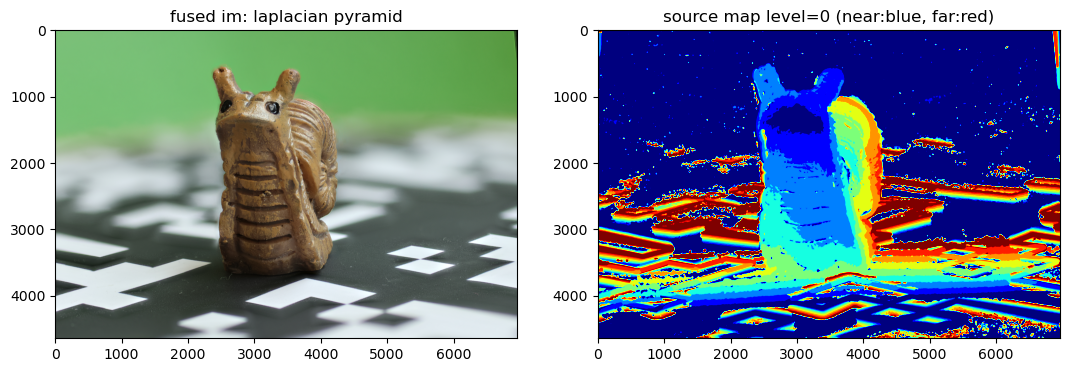

In [31]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
ax1.title.set_text('fused im: laplacian pyramid')
ax1.imshow(im_utils.bgr_to_rgb(fused_im)/255)
ax2.title.set_text(f'source map level=0 (near:blue, far:red)')
ax2.imshow(reconstruction_pyramid.levels[0]['indices'], cmap='jet')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [30]:
cv2.imwrite('lap_pyr.png', fused_im)

True